In [2]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from ahrs.filters import Madgwick
from ahrs.common.orientation import q2euler
from PIL import Image, ImageDraw
import os
import seaborn as sns



# Function to plot heatmap
def plot_heatmap(x, y, value, title,signature_id):
    # Create a pivot table with mean value for each x,y position
    
    heatmap_data = pd.pivot_table(data, values=value, index='y', columns='x', aggfunc=np.mean)
    heatmap_data = heatmap_data.T  # 转置DataFrame
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.title(title)
    sns.heatmap(heatmap_data, cmap='viridis', cbar=False)
    plt.gca().invert_yaxis()  # Invert y axis to match the coordinate system
    

    save_dir='hm_data/'
    base_dir = os.path.splitext(signature_id)[0]  # 基础文件夹路径
    base_dir =os.path.basename(base_dir)

    signature_folder_name = os.path.splitext(title)[0] + '.png'


    target_dir = os.path.join(save_dir,base_dir)
    print(target_dir)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    file_path = os.path.join(target_dir, signature_folder_name)
    plt.savefig(file_path)
    # plt.show()  # 显示图像
    # plt.close()
    




In [3]:
#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.data_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.data_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.data_path)


data_path =  sorted(glob.glob(r'imu_data/*.csv'))#数据文件夹路径，根据实际情况更改！！
new_imu_dir = '/home/yl7723/work/AML_LAB/hm_data' 
signature_dataset = Mydataset(data_path)
print(len(signature_dataset)) #返回文件夹中图片总个数


species = ['False','True']
species_to_id = dict((c, i) for i, c in enumerate(species))
#print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
#print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for imu in data_path:
    # 区分出每个img，应该属于什么类别
    for i, c in enumerate(species):
        if c in imu:
            all_labels.append(i)
print(all_labels) #得到所有标签 

80
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [3]:
# data_path = sorted(glob.glob(r'/AML_LAB/imu_data/*.csv'))#数据文件夹路径，根据实际情况更改！
# for var in data_path:
#     data = pd.read_csv(var)
#     plot_heatmap(data['x'], data['y'], 'pressure', 'Pressure',var)
#     # Plot heatmap for pitch
#     plot_heatmap(data['x'], data['y'], 'pitch', 'Pitch',var)

#     # Plot heatmap for roll
#     plot_heatmap(data['x'], data['y'], 'roll', 'Roll',var)

#     # Plot heatmap for yaw
#     plot_heatmap(data['x'], data['y'], 'yaw', 'Yaw',var)

In [8]:
from PIL import Image
import numpy as np
import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SignatureDataset(Dataset):
    def __init__(self, root_dir, labels,transform=None):
        """
        root_dir: 存储所有图像的根目录路径
        transform: 应用于每个堆叠图像的转换操作
        """
        self.root_dir = root_dir
        self.transform = transform
        self.labels = labels
        # 假设每个签名的文件夹都存储了四个通道的图像
        self.signatures = sorted(glob.glob(root_dir + '/*/'))
        
                        
    def __len__(self):
        return len(self.signatures)

    def __getitem__(self, idx):
        signature_dir = self.signatures[idx]
        channels = ['Pressure', 'Pitch', 'Roll', 'Yaw']
        images = []
        label = self.labels[idx]
        for channel in channels:
            img_path_list = sorted(glob.glob(signature_dir + f'*{channel}.png'))  # 这将返回一个列表
            if img_path_list:  # 确保列表不为空
                img_path = img_path_list[0]  # 选择列表中的第一个元素
                image = Image.open(img_path).convert('L')  # 现在img_path是一个字符串，指向文件路径
                images.append(np.array(image))
            else:
                print(f"No image found for channel {channel} in {signature_dir}")

        # 堆叠图像
        stacked_image = np.stack(images, axis=-1)

        if self.transform:
            # 如果transform期望的是PIL图像，需要先将numpy数组转换回PIL图像
            stacked_image = Image.fromarray(stacked_image)
            stacked_image = self.transform(stacked_image)

        return stacked_image,label

# 定义转换操作
transform = transforms.Compose([
    transforms.Resize((850, 1050)),  # 首先缩放到略大的尺寸
    transforms.RandomCrop((800, 1000)),  # 随机裁剪回原始尺寸
    #transforms.RandomRotation(10),  # 随机旋转，这里的角度为示例
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 如果适用
    transforms.ToTensor(),  # 将PIL图像或NumPy ndarray转换为tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])  # 正则化四个通道
])





root_dir='hm1_data'

# 创建数据集实例
signature_dataset = SignatureDataset(root_dir, all_labels, transform=transform)
print(signature_dataset)
# 示例：查看第一个堆叠的图像





In [9]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split





# 假设 signature_dataset 是你的完整数据集
total_size = len(signature_dataset)
train_size = int(0.6 * total_size)
valid_size = int(0.2 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(signature_dataset, [train_size, valid_size, test_size])





batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




## Simple CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim






class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Regularization layers
        self.dropout1 = nn.Dropout(0.5)  # Increased dropout
        self.dropout2 = nn.Dropout(0.5)  # Additional dropout layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 100 * 125, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Apply convolutions, batch norm, activation, pooling and dropout
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 100 * 125)  # Flatten operation
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout2(x)  # Additional dropout before the final layer
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # Weight initialization can sometimes improve training
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 创建模型实例
model_CNN = ImprovedCNN(num_classes=2)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.003, weight_decay=1e-4)  # Added weight decay for regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)


# 检查是否支持GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN.to(device)

# 初始化用于绘图的损失和准确率列表
train_losses = []
train_accuracies = []

# 进行训练
for epoch in range(20):  # 假设训练15个epoch
    model_CNN.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将数据移动到GPU
        optimizer.zero_grad()  # 梯度清零
        outputs = model_CNN(signatures)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        running_loss += loss.item()  # 累加损失
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
print(f"Validation Accuracy: {100 * correct / total:.2f}%")
# 绘制损失图
plt.plot(train_losses, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确率图
plt.plot(train_accuracies, label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Resnet 

/home/lycho-_-/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lycho-_-/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lycho-_-/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch [1/50], Training Loss: 0.7953, Training Accuracy: 0.5417, Validation Loss: 1.1022, Validation Accuracy: 0.4375
Epoch [2/50], Training Loss: 0.6942, Training Accuracy: 0.6042, Validation Loss: 0.6684, Validation Accuracy: 0.6875
Epoch [3/50], Training Loss: 0.6361, Training Accuracy: 0.6250, Validation Loss: 0.6435, Validation Accuracy: 0.7500
Epoch [4/50], Training Loss: 0.5510, Training Accuracy: 0.7708, Validation Loss: 0.5862, Validation Accuracy: 0.8125
Epoch [5/50], Training Loss: 0.3563, Training Accuracy: 0.8958, Validation Loss: 1.2040, Validation Accuracy: 0.7500
Epoch [6/50], Training Loss: 0.2768, Training Accuracy: 0.8542, Validation Loss: 1.1915, Validation Accuracy: 0.6250
Epoch [7/50], Training Loss: 0.3320, Training Accuracy: 0.8750, Validation Loss: 0.5576, Validation Accuracy: 0.8125
Epoch [8/50], Training Loss: 0.2569, Training Accuracy: 0.8958, Validation Loss: 1.0646, Validation Accuracy: 0.6875
Epoch [9/50], Training Loss: 0.1253, Training Accuracy: 0.9792, 

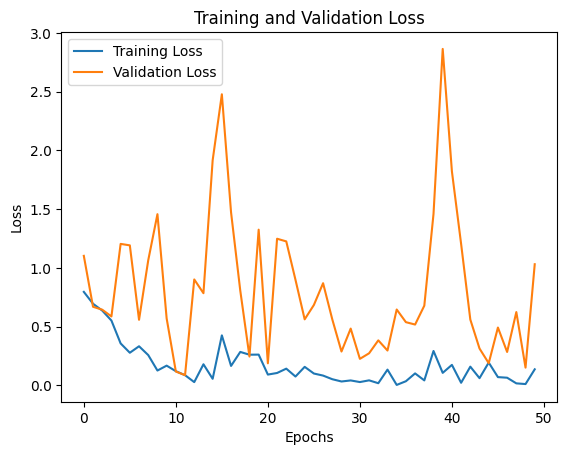

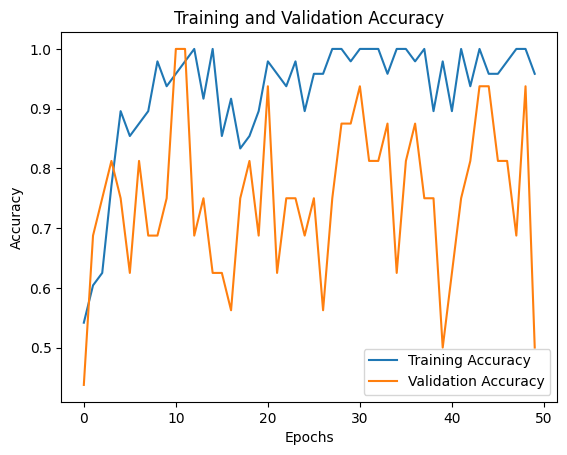

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models


# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分


# 初始化ResNet模型
model_resnet = models.resnet18(pretrained=True)# 修改第一层卷积以接受4个通道的输入
conv1_old = model_resnet.conv1
model_resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
with torch.no_grad():
    model_resnet.conv1.weight[:, :3] = conv1_old.weight
    model_resnet.conv1.weight[:, 3] = model_resnet.conv1.weight[:, 0]  # 复制第一个通道的权重


num_classes = 2
# 修改全连接层以匹配类别数
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # 增加Dropout
    nn.Linear(num_ftrs, num_classes)
)
criterion = nn.CrossEntropyLoss()  # 选择适合你任务的损失函数
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 设置优化器和损失函数


# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet.to(device)

# ...（前面的模型定义和优化器定义保持不变）...

# 初始化用于绘图的损失和准确率列表
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 训练循环
for epoch in range(50):  # 假设训练20个epoch
    # 在训练集上训练
    model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将数据移动到GPU
        optimizer.zero_grad()  # 梯度清零
        outputs = model_resnet(signatures)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        running_loss += loss.item()  # 累加损失
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)
        correct += (predicted == labels).sum().item()        # ...训练步骤...

    # 保存训练损失和准确率
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 在验证集上验证
    model_resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_signatures, val_labels in valid_loader:
            val_signatures, val_labels = val_signatures.to(device), val_labels.to(device)
            val_outputs = model_resnet(val_signatures)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    # 保存验证损失和准确率
    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(val_correct / val_total)

    # 打印训练和验证结果
    print(f"Epoch [{epoch+1}/50], Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

# 在测试集上测试
model_resnet.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for test_signatures, test_labels in test_loader:
        test_signatures, test_labels = test_signatures.to(device), test_labels.to(device)
        test_outputs = model_resnet(test_signatures)
        t_loss = criterion(test_outputs, test_labels)
        test_loss += t_loss.item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

# 计算测试损失和准确率
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 绘制训练、验证和测试结果
# ...（绘图代码保持不变，您可以添加一个新的图表来显示测试准确率，如果需要的话）
# 绘制训练损失和验证损失在同一张图上
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率和验证准确率在同一张图上
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from torchvision import models

model_alex = models.alexnet(pretrained=True)

# 修改第一个卷积层，以接受4个通道的输入
# 注意：AlexNet的第一个卷积层的名称是'features[0]'
model_alex.features[0] = nn.Conv2d(4, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

# 修改最后的全连接层，以输出正确数量的类别
num_classes = 2
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alex.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alex.to(device)

# 初始化用于绘图的损失和准确率列表
train_losses = []
train_accuracies = []

# 进行训练
for epoch in range(15):  # 假设训练15个epoch
    model_CNN.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将数据移动到GPU
        optimizer.zero_grad()  # 梯度清零
        outputs = model_CNN(signatures)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        running_loss += loss.item()  # 累加损失
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"Epoch [{epoch+1}/15], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# 绘制损失图
plt.plot(train_losses, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确率图
plt.plot(train_accuracies, label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/home/yl7723/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Loss: 1.0649861097335815
Epoch [2/15], Loss: 0.758153464112963
Epoch [3/15], Loss: 0.7628251739910671
Epoch [4/15], Loss: 0.8146492072514125
Epoch [5/15], Loss: 0.7235020313944135
Epoch [6/15], Loss: 0.7544785397393363
Epoch [7/15], Loss: 0.7674180609839303
Epoch [8/15], Loss: 0.6927117705345154
Epoch [9/15], Loss: 0.7151419179780143
Epoch [10/15], Loss: 0.6990198067256382
Epoch [11/15], Loss: 0.694000746522631
Epoch [12/15], Loss: 0.7017064946038383
Epoch [13/15], Loss: 0.6967441780226571
Epoch [14/15], Loss: 0.6945398790495736
Epoch [15/15], Loss: 0.6922840561185565
correct 4
wrong 4
correct 8
wrong 8
correct 11
wrong 13
Validation Accuracy: 45.83%
Accuracy of the network on the test images: 45 %


torch.Size([4, 800, 1000])


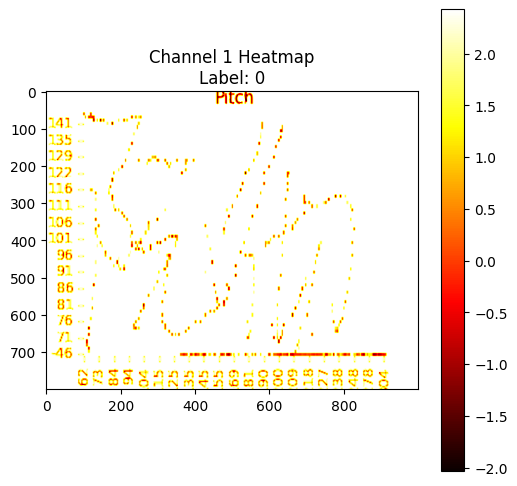

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # 确保导入了torch

# 假设 image_data 是从数据集中获取的一个元素，形式为 (image, label)
image_data = signature_dataset[2]  # 假设signature_dataset是你的数据集
image, label = image_data  # 分别提取图像和标签

# 确保图像在CPU上
image = image.cpu()
print(image.shape)
# 选择要可视化的通道，例如第一个通道
channel = 1
if image.shape[0] == 4:
    image_rgb = image[:3, :, :]  # 选择前3个通道

# 将图像数据转换为NumPy数组，用于绘图
image_np = image_rgb.permute(1, 2, 0).numpy()  # 重新排列轴，以适应matplotlib的[H, W, C]格式

# 将图像通道数据转换为NumPy数组，用于绘图
image_channel = image[channel].numpy()

# 绘制热图
plt.figure(figsize=(6, 6))
plt.imshow(image_channel, cmap='hot')
plt.colorbar()  # 显示颜色条
plt.title(f'Channel {channel} Heatmap\nLabel: {label}')
plt.show()


In [ ]:
import torch
print('CUDA版本:',torch.version.cuda)
print('Pytorch版本:',torch.__version__)
print('显卡是否可用:','可用' if(torch.cuda.is_available()) else '不可用')
print('显卡数量:',torch.cuda.device_count())
print('是否支持BF16数字格式:','支持' if (torch.cuda.is_bf16_supported()) else '不支持')
print('当前显卡型号:',torch.cuda.get_device_name())
print('当前显卡的CUDA算力:',torch.cuda.get_device_capability())
print('当前显卡的总显存:',torch.cuda.get_device_properties(0).total_memory/1024/1024/1024,'GB')
print('是否支持TensorCore:','支持' if (torch.cuda.get_device_properties(0).major >= 7) else '不支持')
print('当前显卡的显存使用率:',torch.cuda.memory_allocated(0)/torch.cuda.get_device_properties(0).total_memory*100,'%')

CUDA版本: 12.1
Pytorch版本: 2.2.1+cu121
显卡是否可用: 可用
显卡数量: 4
是否支持BF16数字格式: 支持
当前显卡型号: NVIDIA GeForce RTX 3090
当前显卡的CUDA算力: (8, 6)
当前显卡的总显存: 23.69110107421875 GB
是否支持TensorCore: 支持
当前显卡的显存使用率: 0.0 %
